## Capstone 3: Unsupervised learning
# Clustering of customers data with vehicles insurance policies

For this project I'm suing dataset of customers with vehicle insurance policies, which I found on kaggle https://www.kaggle.com/ranja7/vehicle-insurance-customer-data .

These socio-economic data with details about auto insurance polices of the customer can be used to for analyzing their behavior enabling targeted  marketing to offer more personalized policies to them.

In this project I will use different unsupervised learning techniques to cluster customer to better understand their behavior. The results of this project could be useful to insurance companies, because by understanding customers behavior companies can provide better services according customers needs, increase customer's satisfaction, and as a result increase companies' profit and minimize losses.   

In [62]:
import pandas as pd
import requests
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
import prince
import umap
import warnings 
warnings.simplefilter("ignore")
import hvplot.pandas
import hvplot.dask 

## Data exploration and preparation for analysis

In [38]:
#https://www.kaggle.com/ranja7/vehicle-insurance-customer-data
df_ins=pd.read_csv('Data/vehicle-insurance-customer-data.zip', compression='zip')
# dataset contains colunm 'Customer', which contain unique ID of customer
# and can be used as dataframe index
df_ins_ind=df_ins.set_index('Customer')

In [39]:
df_ins_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, BU79786 to Y167826
Data columns (total 23 columns):
State                            9134 non-null object
Customer Lifetime Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               9134 non-null int64
Policy Type                   

The dataset contains information about 9134 unique customers. It has 23 features, which is combination of categorical and numeric data. First I convert 'Effective To Date' to pandas date-time format.

In [41]:
# Only month is gonna be used in the model, becuase this data contains records for 2011 only
df_ins_ind['Effective To Date'] = pd.to_datetime(df_ins_ind['Effective To Date'])
df_ins_ind['month']=pd.DatetimeIndex(df_ins_ind['Effective To Date']).month
df_ins = df_ins_ind.drop(columns=['Effective To Date'])

Next I build correlation map to see if some numerical features correlate with each other

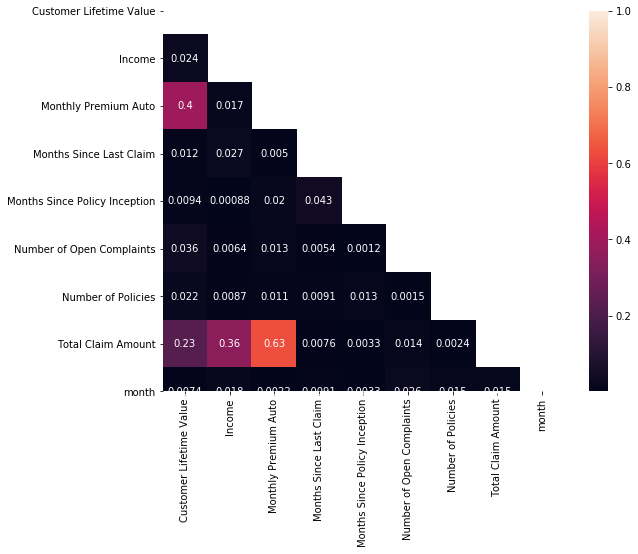

In [42]:
mask = np.zeros_like(abs(df_ins.corr()) , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(9, 7))
sns.heatmap(abs(df_ins.corr()) , mask=mask, annot=True)

Total claim amount has high correlation coefficient with Monthly premiums. This make sense because premiums usually go up when customer files a claim. 

To prepare data for modeling I convert categorical  data to numeric by using LabelEncoder.

In [43]:
# list of no-numeric columns
list_encode = df_ins.select_dtypes(include=np.object).columns.tolist()
# lsit of numeric colums
list_num_col = df_ins.select_dtypes(include=np.number).columns.tolist()

# dictionary, which will contain encoded data
le_dict={}
# dataset with encoded categorical data
df_le = pd.DataFrame(index=df_ins.index)

le=LabelEncoder()
for name in list_encode:
    df_le[name] = le.fit_transform(df_ins[name])
    le_dict[name]=le.classes_

# dataset with numeric and labelencoded data
df_ins_num = pd.concat([df_le, df_ins[list_num_col]],axis=1)    

for item in le_dict:
    print(item, le_dict[item])

State ['Arizona' 'California' 'Nevada' 'Oregon' 'Washington']
Response ['No' 'Yes']
Coverage ['Basic' 'Extended' 'Premium']
Education ['Bachelor' 'College' 'Doctor' 'High School or Below' 'Master']
EmploymentStatus ['Disabled' 'Employed' 'Medical Leave' 'Retired' 'Unemployed']
Gender ['F' 'M']
Location Code ['Rural' 'Suburban' 'Urban']
Marital Status ['Divorced' 'Married' 'Single']
Policy Type ['Corporate Auto' 'Personal Auto' 'Special Auto']
Policy ['Corporate L1' 'Corporate L2' 'Corporate L3' 'Personal L1' 'Personal L2'
 'Personal L3' 'Special L1' 'Special L2' 'Special L3']
Renew Offer Type ['Offer1' 'Offer2' 'Offer3' 'Offer4']
Sales Channel ['Agent' 'Branch' 'Call Center' 'Web']
Vehicle Class ['Four-Door Car' 'Luxury Car' 'Luxury SUV' 'SUV' 'Sports Car'
 'Two-Door Car']
Vehicle Size ['Large' 'Medsize' 'Small']


Education columns contain  categorical ordinal data, but order of degrees is not right, and need to be corrected. 

In [44]:
map_edu=  {'High School or Below':0,        
           'College':1,           
           'Bachelor':2,
           'Master':3,
           'Doctor':4}
le_dict['Education']=list(map_edu.keys())
df_ins_num['Education'] =df_ins['Education'].map(map_edu)
for item in le_dict:
    print(item, le_dict[item])

State ['Arizona' 'California' 'Nevada' 'Oregon' 'Washington']
Response ['No' 'Yes']
Coverage ['Basic' 'Extended' 'Premium']
Education ['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']
EmploymentStatus ['Disabled' 'Employed' 'Medical Leave' 'Retired' 'Unemployed']
Gender ['F' 'M']
Location Code ['Rural' 'Suburban' 'Urban']
Marital Status ['Divorced' 'Married' 'Single']
Policy Type ['Corporate Auto' 'Personal Auto' 'Special Auto']
Policy ['Corporate L1' 'Corporate L2' 'Corporate L3' 'Personal L1' 'Personal L2'
 'Personal L3' 'Special L1' 'Special L2' 'Special L3']
Renew Offer Type ['Offer1' 'Offer2' 'Offer3' 'Offer4']
Sales Channel ['Agent' 'Branch' 'Call Center' 'Web']
Vehicle Class ['Four-Door Car' 'Luxury Car' 'Luxury SUV' 'SUV' 'Sports Car'
 'Two-Door Car']
Vehicle Size ['Large' 'Medsize' 'Small']


# Data analysis 
## Dimensionality reduction


First I apply dimensionality reductions techniques like PCA, to visualize data

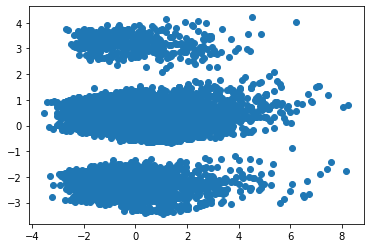

In [45]:
# scalling data with StandartScaller to it for PCA
X_std = StandardScaler().fit_transform(df_ins_num)
x_pc = PCA(n_components=2).fit_transform(X_std)
plt.scatter(x_pc[:,0],x_pc[:,1])

Scatter plot of two principal components of data shows three distinct clusters (I analyze those clusters in the next section) 

UMAP is other powerful technique for dimensionality reduction and visualization.

Wall time: 21.4 s


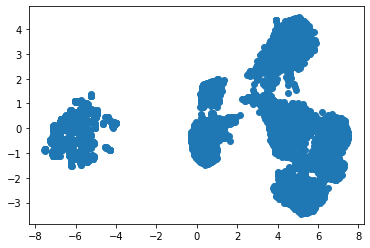

In [48]:
%%time
umap_results = umap.UMAP(n_neighbors=28,
                      min_dist=0.04,
                      metric='euclidean').fit_transform(X_std)
plt.scatter(umap_results[:,0], umap_results[:,1]);

As PCA UMAP also produces three separate clusters, however one can see some fine structure in the biggest cluster from UMP method.

Both PCA and UMAP produce clusters of non-spherical shape, so DBSCAN is the best technique to cluster the data

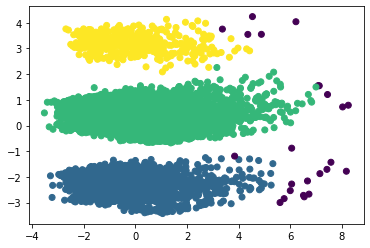

In [49]:
x_pc_DB = DBSCAN(eps=0.5).fit_predict(x_pc)
plt.scatter(x_pc[:,0],x_pc[:,1],c=x_pc_DB)

array([0, 1, 2], dtype=int64)

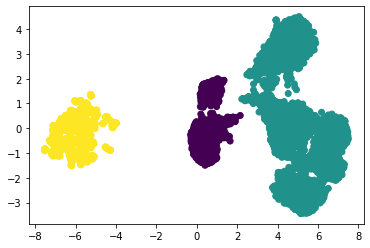

In [54]:
x_um =DBSCAN(eps=0.6,min_samples=4).fit_predict(umap_results)
plt.scatter(umap_results[:,0],umap_results[:,1],c=x_um)
np.unique(x_um)

Now all data like x, y components and cluster labels can be combined with original data for further analysis. 

In [55]:
df_ins_clust=df_ins.copy()
df_ins_clust['pca_dbscan']=x_pc_DB
df_ins_clust['umap_dbscan']=x_um
df_ins_clust['x_umap']=umap_results[:,0]
df_ins_clust['y_umap']=umap_results[:,1]
df_ins_clust['x_pca']=x_pc[:,0]
df_ins_clust['y_pca']=x_pc[:,1]

## Cluster analysis

After customers data were cluster it's time to get some characteristics of clusters. First I work with numerical feature, and find average of numerical feature for each cluster and compare them

Average  Customer Lifetime Value
cluster 	 PCA 		 UMAP
0 	 7731.10687559827 	 7584.2245296189385
1 	 8005.007232285694 	 8194.172990608173
2 	 8518.58252679302 	 7617.41482954546


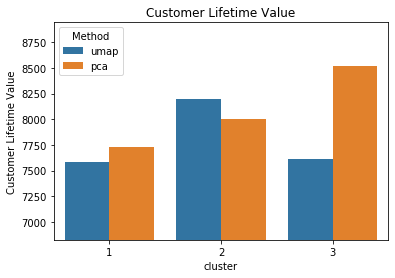

Average  Income
cluster 	 PCA 		 UMAP
0 	 37996.71033776868 	 38001.89199029126
1 	 37558.83770636792 	 37377.98475609756
2 	 39422.93279569892 	 38593.13397129186


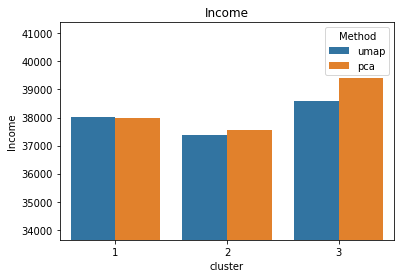

Average  Monthly Premium Auto
cluster 	 PCA 		 UMAP
0 	 92.28863868986694 	 91.43446601941747
1 	 93.10554245283019 	 94.573973042362
2 	 91.31989247311827 	 88.83253588516746


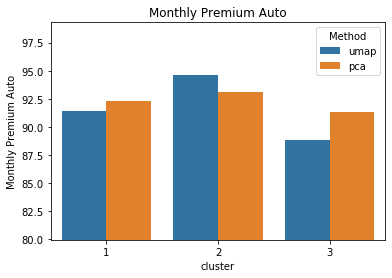

Average  Months Since Last Claim
cluster 	 PCA 		 UMAP
0 	 15.38689866939611 	 15.464805825242719
1 	 15.022110849056604 	 15.097240051347882
2 	 14.817204301075268 	 14.61244019138756


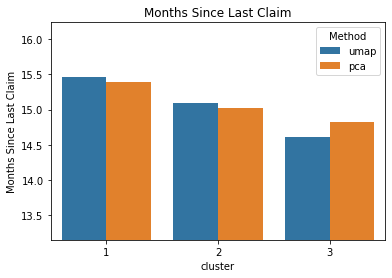

Average  Months Since Policy Inception
cluster 	 PCA 		 UMAP
0 	 47.86489252814739 	 47.640776699029125
1 	 48.19428066037736 	 48.1492297817715
2 	 46.18817204301075 	 48.20095693779904


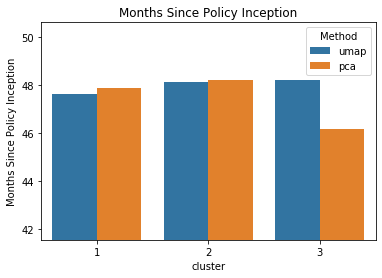

Average  Number of Open Complaints
cluster 	 PCA 		 UMAP
0 	 0.35977482088024565 	 0.3586165048543689
1 	 0.3912146226415094 	 0.3992297817715019
2 	 0.4032258064516129 	 0.3444976076555024


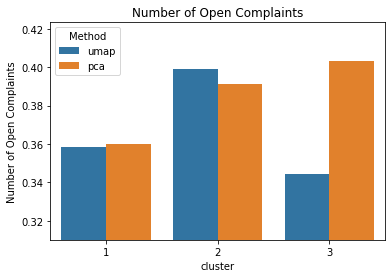

Average  Number of Policies
cluster 	 PCA 		 UMAP
0 	 2.9912998976458547 	 2.9927184466019416
1 	 2.9656544811320753 	 2.982188703465982
2 	 2.879032258064516 	 2.851674641148325


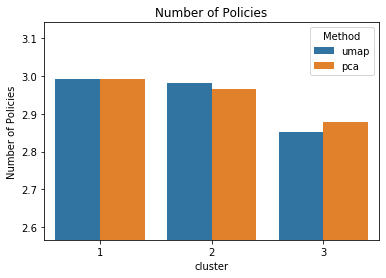

Average  Total Claim Amount
cluster 	 PCA 		 UMAP
0 	 418.3598908249751 	 409.92654347087375
1 	 433.78904030350606 	 443.7638078199604
2 	 425.4941024139787 	 417.7608080382774


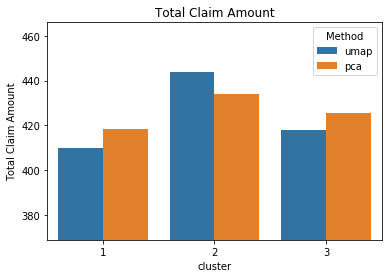

Average  month
cluster 	 PCA 		 UMAP
0 	 3.528147389969294 	 3.525485436893204
1 	 3.4686025943396226 	 3.522625160462131
2 	 3.225806451612903 	 3.1148325358851676


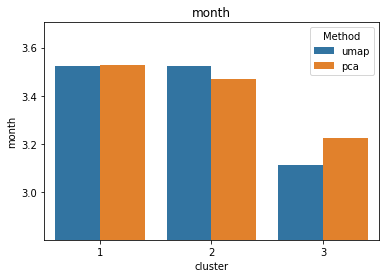

In [58]:
# loop over all numerical columns
for name in list_num_col:
    var_of_interest = name
    print('Average ', var_of_interest)
    print('cluster \t PCA \t\t UMAP')
    lst_cluster =[1,2,3] # list of cluster indices
    lst_pc=[]          # EMPTY list where means of clsuters (PCA) will be stored  
    lst_umap=[]        # EMPTY list where means of clsuters (UMAP) will be stored 
    for i in range(3): 
        lst_pc.append(df_ins_clust[df_ins_clust['pca_dbscan']==i][var_of_interest].mean())
        lst_umap.append(df_ins_clust[df_ins_clust['umap_dbscan']==i][var_of_interest].mean())
        print(i,'\t', df_ins_clust[df_ins_clust['pca_dbscan']==i][var_of_interest].mean(),'\t',
             df_ins_clust[df_ins_clust['umap_dbscan']==i][var_of_interest].mean())

    df_plot=pd.DataFrame( list(zip(lst_cluster,lst_pc,lst_umap)), columns = ['cluster', 'pca','umap'] )
    # data frame for bar plot
    tidy = pd.melt(df_plot,id_vars=['cluster'], 
                   value_vars = ['umap','pca'], 
                   value_name=var_of_interest,
                   var_name = 'Method')
    plt.title(var_of_interest)
    bp= sns.barplot(data=tidy, x='cluster', y=var_of_interest, hue='Method')
    #setting lower limit of bar plot to better see differnce between bars
    bp.set_ylim(0.9*tidy[var_of_interest].min() ,) 
    plt.show();

From bar plots we can see that means of numerical features from different clusters are different. For example on average customers from cluster 3 have higher income that from cluster 2, and customers from cluster 3 pay less premium that from cluster 2. Customers from cluster 2 pay higher premium maybe because they have high (on average) claimed amount.
For some numerical features clusters obtained from PC and UMAP significantly different average values, possibly because PCA and UMAP produce clusters of different size and shape.

Now time to analyze categorical feature distributed over clusters. For that I use scatterplot to plot UMAP and PC data, and use categorical data to colorize datapoints.  


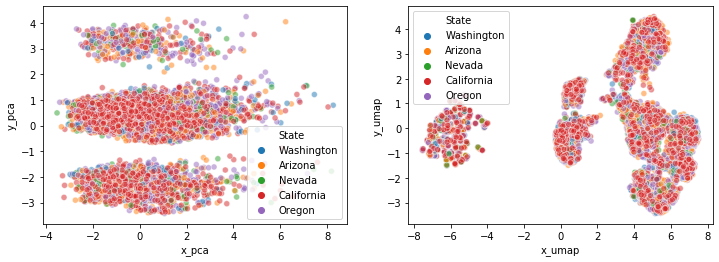

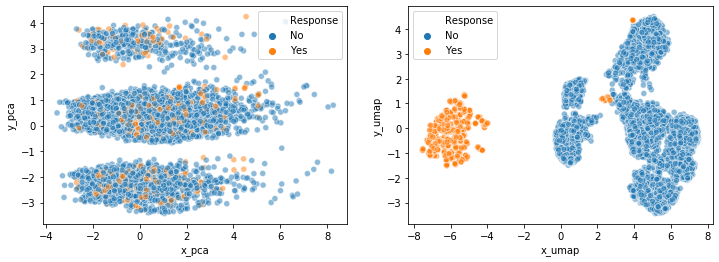

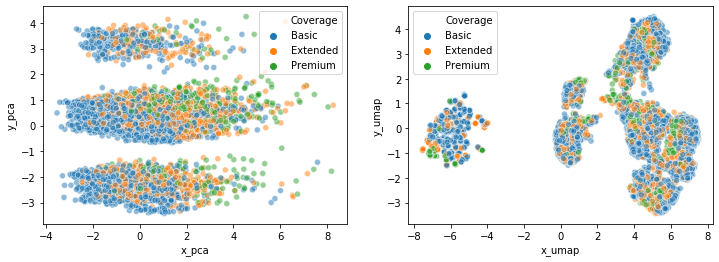

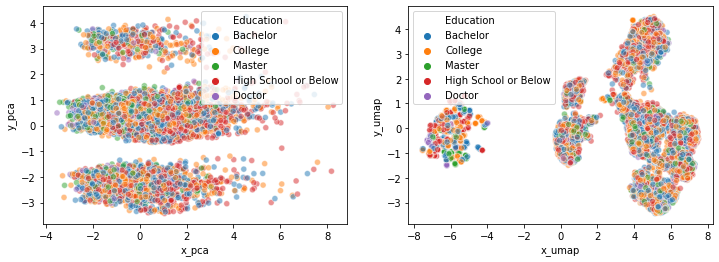

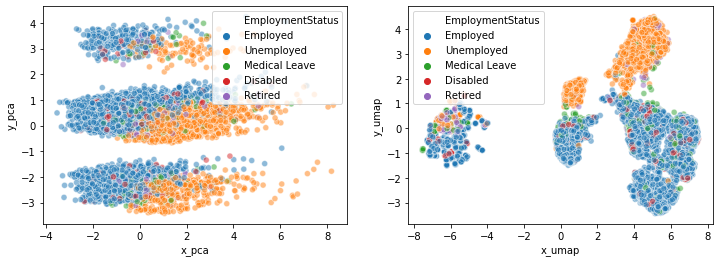

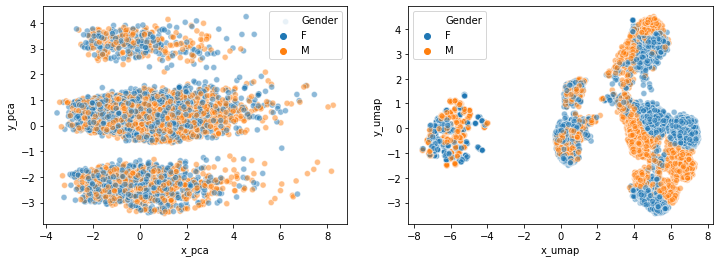

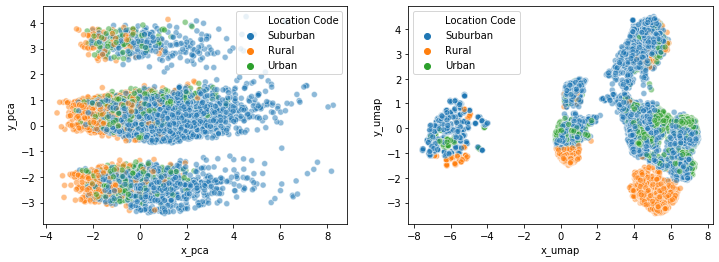

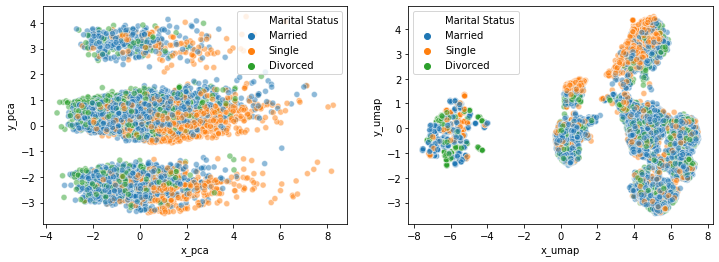

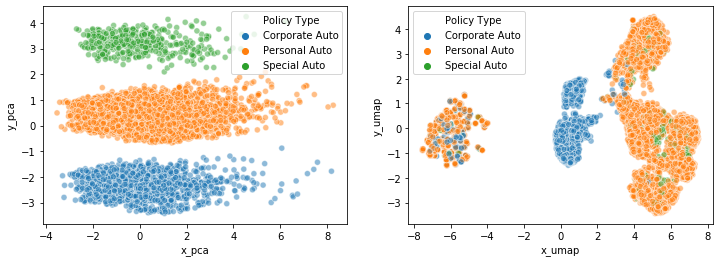

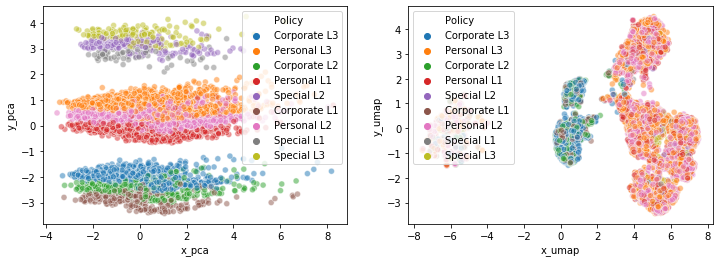

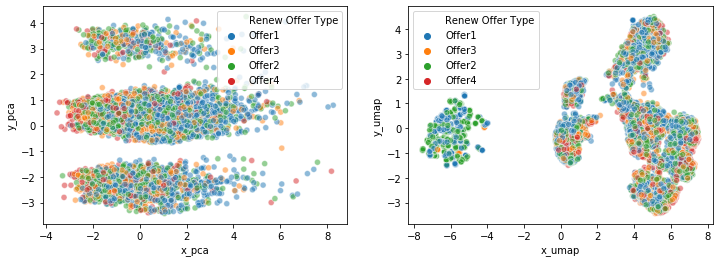

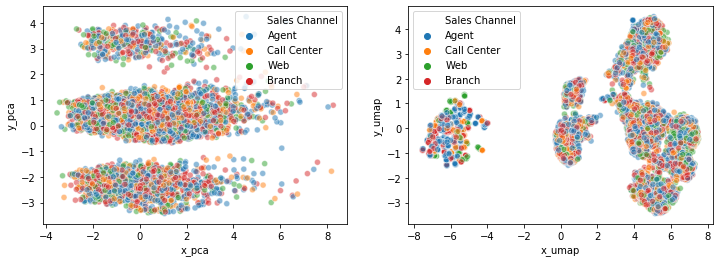

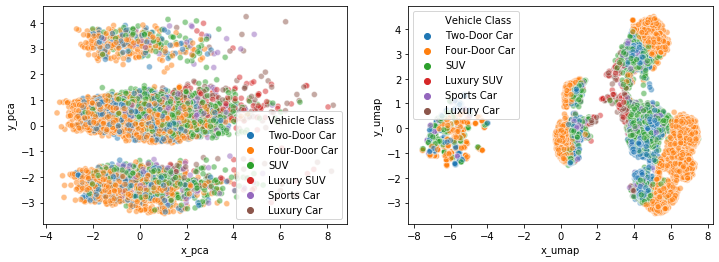

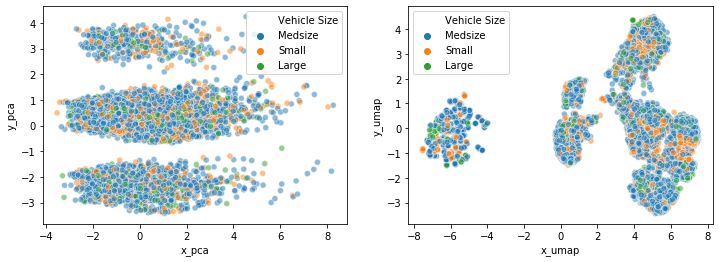

In [60]:
for name in list_encode:
    plt.figure(figsize=(12,4))
    plt.title(name) 
    plt.subplot(1,2,1) 
    sns.scatterplot(data =df_ins_clust, x='x_pca', y='y_pca',hue=name, alpha=0.5 )
    plt.subplot(1,2,2)
    sns.scatterplot(data =df_ins_clust, x='x_umap', y='y_umap',hue=name, alpha=0.5 )
    plt.show();

From scatter of UMAP data we can see that almost all customers with Yes Response assigned to one cluster. Then from PC plot for Coverage category we can see that customers with basic coverage are located on the left hand side of the plot, extended coverage in the  middle and with premium coverage on the right hand side. 

Looking on the employment status we can see Employed and Unemployed customers are concentrated in some area in PC and UMAP data.

Clusters from PCA data correspond to different types of Policy: top cluster for Special Auto, medium cluster for Personal and bottom cluster for Corporate Auto policies. 

## MCA and FAMD

For further analysis I try multi-component analysis (MCA) for categorical data and principal component analysis (PCA) for numerical data separately. 

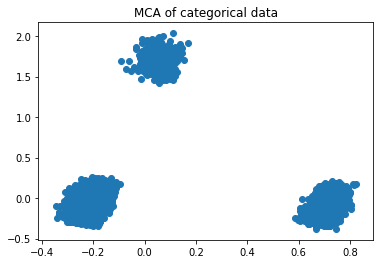

In [67]:
mca = prince.MCA(n_components=2,
                 n_iter=3,
                 copy=True,
                 engine='auto')

mca = mca.fit(df_ins[list_encode])
mca_tr = mca.fit_transform(df_ins[list_encode])
plt.title ('MCA of categorical data')
plt.scatter(mca_tr[0],mca_tr[1])

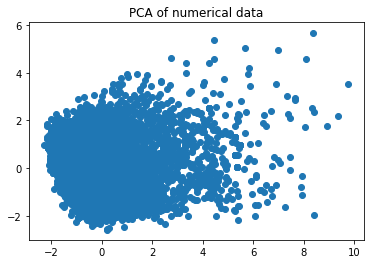

In [68]:
X_std_cont = StandardScaler().fit_transform(df_ins[list_num_col])
x_pc_cont = PCA(n_components=4).fit_transform(X_std_cont)
plt.title ('PCA of numerical data')
plt.scatter(x_pc_cont[:,0],x_pc_cont[:,1])

MCA produces three distinct clusters,  however PCA does not produce any visually dsitinct clusters. So it looks like only using categorical data customers can be clustered.  

Next I plot MCA results for different categorical features to how they are clustered. 

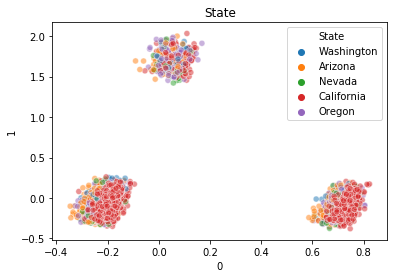

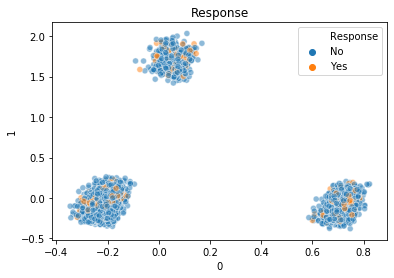

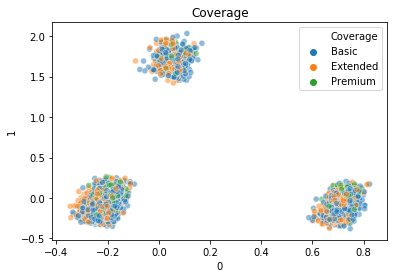

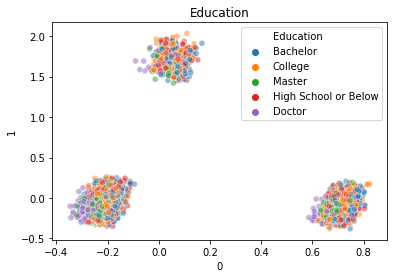

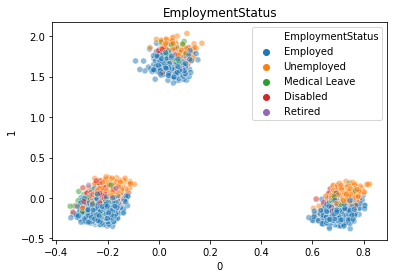

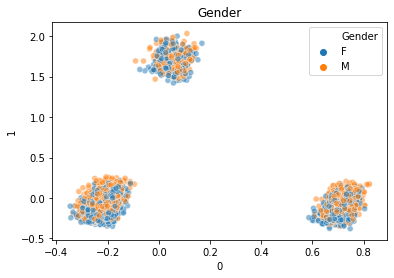

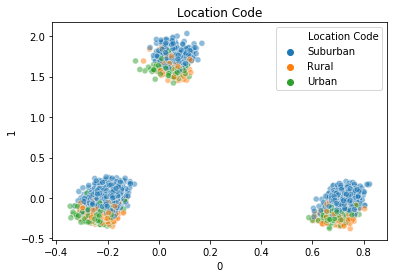

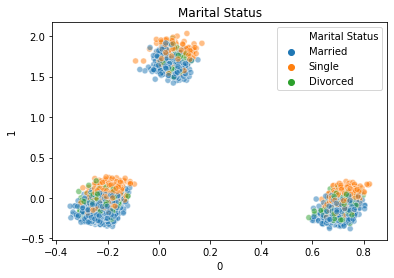

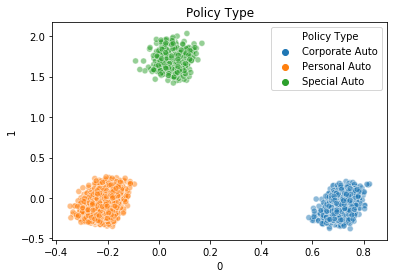

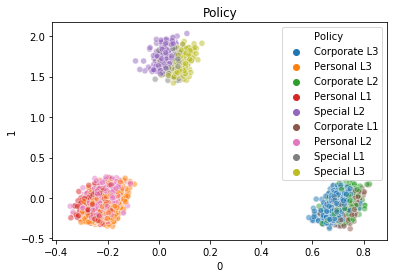

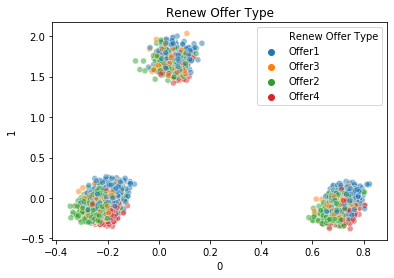

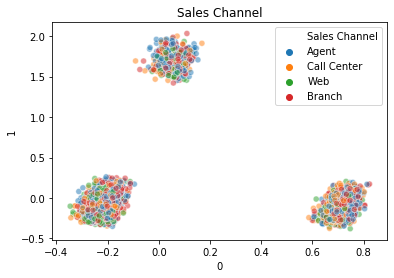

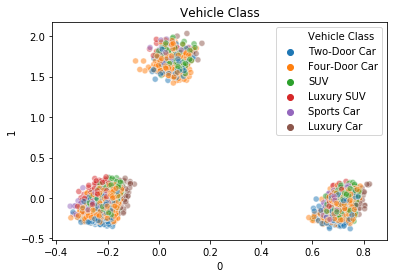

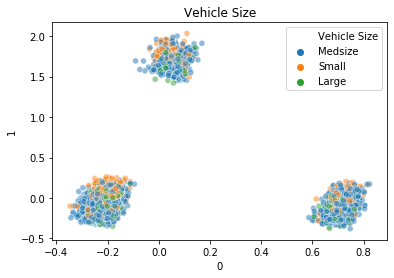

In [72]:
for name in list_encode:
    plt.title(name)
    sns.scatterplot(x=mca_tr[0],y= mca_tr[1], hue=df_ins[name], alpha=0.5 )
    plt.show();

We can see that Policy Type is a feature which different for all three clusters. 


Next I try factor analysis of mixed data (FAMD) from prince module to see mixed categorical and numeric data can be clustered.

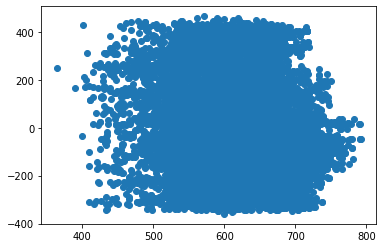

In [74]:
famd = prince.FAMD(n_components=2,copy=True,n_iter=100,engine='auto', random_state=34)
famd_fit = famd.fit(df_ins)
famd_fit_tr = famd.fit_transform(df_ins)
plt.scatter(famd_fit_tr[0],famd_fit_tr[1])

After tuning hyperparameters FAMD was not able to produce any visually good results. 

# Conclusion 